<a href="https://colab.research.google.com/github/spour/DeepExplain/blob/master/deepexplain_refactor_tf2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import sys
import numpy as np
from skimage.util import view_as_windows
import warnings, logging
import tensorflow as tf
from tensorflow.python.framework import ops
from tensorflow.python.ops import nn_grad, math_grad
from collections import OrderedDict
import numpy as np
import tensorflow as tf
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

# Some of the following functions for batch processing have been borrowed and adapter from Keras
# https://github.com/keras-team/keras/blob/master/keras/utils/generic_utils.py
# https://github.com/keras-team/keras/blob/master/keras/engine/training_utils.py


def make_batches(size, batch_size):
    """Returns a list of batch indices (tuples of indices).
    # Arguments
        size: Integer, total size of the data to slice into batches.
        batch_size: Integer, batch size.
    # Returns
        A list of tuples of array indices.
    """
    num_batches = (size + batch_size - 1) // batch_size  # round up
    return [(i * batch_size, min(size, (i + 1) * batch_size))
            for i in range(num_batches)]


def to_list(x, allow_tuple=False):
    """Normalizes a list/tensor into a list.
    If a tensor is passed, we return
    a list of size 1 containing the tensor.
    # Arguments
        x: target object to be normalized.
        allow_tuple: If False and x is a tuple,
            it will be converted into a list
            with a single element (the tuple).
            Else converts the tuple to a list.
    # Returns
        A list.
    """
    if isinstance(x, list):
        return x
    if allow_tuple and isinstance(x, tuple):
        return list(x)
    return [x]


def unpack_singleton(x):
    """Gets the equivalent np-array if the iterable has only one value.
    Otherwise return the iterable.
    # Argument
        x: A list or tuple.
    # Returns
        The same iterable or the iterable converted to a np-array.
    """
    if len(x) == 1:
        return np.array(x)
    return x


def slice_arrays(arrays, start=None, stop=None):
    """Slices an array or list of arrays.
    """
    if arrays is None:
        return [None]
    elif isinstance(arrays, list):
        return [None if x is None else x[start:stop] for x in arrays]
    else:
        return arrays[start:stop]


def placeholder_from_data(numpy_array):
    if numpy_array is None:
        return None
    return tf.compat.v1.placeholder('float', [None,] + list(numpy_array.shape[1:]))

SUPPORTED_ACTIVATIONS = [
    'Relu', 'Elu', 'Sigmoid', 'Tanh', 'Softplus'
]

UNSUPPORTED_ACTIVATIONS = [
    'CRelu', 'Relu6', 'Softsign'
]

_ENABLED_METHOD_CLASS = None
_GRAD_OVERRIDE_CHECKFLAG = 0


# -----------------------------------------------------------------------------
# UTILITY FUNCTIONS
# -----------------------------------------------------------------------------


def activation(type):
    """
    Returns Tensorflow's activation op, given its type
    :param type: string
    :return: op
    """
    if type not in SUPPORTED_ACTIVATIONS:
        warnings.warn('Activation function (%s) not supported' % type)
    f = getattr(tf.nn, type.lower())
    return f


def original_grad(op, grad):
    """
    Return original Tensorflow gradient for an op
    :param op: op
    :param grad: Tensor
    :return: Tensor
    """
    if op.type not in SUPPORTED_ACTIVATIONS:
        warnings.warn('Activation function (%s) not supported' % op.type)
    opname = '_%sGrad' % op.type
    if hasattr(nn_grad, opname):
        f = getattr(nn_grad, opname)
    else:
        f = getattr(math_grad, opname)
    return f(op, grad)


# -----------------------------------------------------------------------------
# ATTRIBUTION METHODS BASE CLASSES
# -----------------------------------------------------------------------------


class AttributionMethod(object):
    """
    Attribution method base class
    """
    def __init__(self, T, X, session, keras_learning_phase=None):
        self.T = T  # target Tensor
        self.X = X  # input Tensor
        self.Y_shape = [None,] + T.get_shape().as_list()[1:]
        # Most often T contains multiple output units. In this case, it is often necessary to select
        # a single unit to compute contributions for. This can be achieved passing 'ys' as weight for the output Tensor.
        self.Y = tf.compat.v1.placeholder(tf.float32, self.Y_shape)
        # placeholder_from_data(ys) if ys is not None else 1.0  # Tensor that represents weights for T
        self.T = self.T * self.Y
        self.symbolic_attribution = None
        self.session = session
        self.keras_learning_phase = keras_learning_phase
        self.has_multiple_inputs = type(self.X) is list or type(self.X) is tuple
        logging.info('Model with multiple inputs: %s' % self.has_multiple_inputs)

        # Set baseline
        # TODO: now this sets a baseline also for those methods that does not require it
        self._set_check_baseline()

        # References
        self._init_references()

        # Create symbolic explanation once during construction (affects only gradient-based methods)
        self.explain_symbolic()

    def explain_symbolic(self):
        return None

    def run(self, xs, ys=None, batch_size=None):
        pass

    def _init_references(self):
        pass

    def _check_input_compatibility(self, xs, ys=None, batch_size=None):
        if ys is not None:
            if not self.has_multiple_inputs and len(xs) != len(ys):
                raise RuntimeError('When provided, ys must have the same batch size as xs (xs has batch size {} and ys {})'.format(len(xs), len(ys)))
            elif self.has_multiple_inputs and np.all([len(i) != len(ys) for i in xs]):
                raise RuntimeError('When provided, ys must have the same batch size as all elements of xs')
        if batch_size is not None and batch_size > 0:
            if self.T.shape[0].value is not None and self.T.shape[0].value is not batch_size:
                raise RuntimeError('When using batch evaluation, the first dimension of the target tensor '
                                   'must be compatible with the batch size. Found %s instead' % self.T.shape[0].value)
            if isinstance(self.X, list):
                for x in self.X:
                    if x.shape[0].value is not None and x.shape[0].value is not batch_size:
                        raise RuntimeError('When using batch evaluation, the first dimension of the input tensor '
                                           'must be compatible with the batch size. Found %s instead' % x.shape[
                                               0].value)
            else:
                if self.X.shape[0].value is not None and self.X.shape[0].value is not batch_size:
                    raise RuntimeError('When using batch evaluation, the first dimension of the input tensor '
                                       'must be compatible with the batch size. Found %s instead' % self.X.shape[0].value)

    def _session_run_batch(self, T, xs, ys=None):
        feed_dict = {}
        if self.has_multiple_inputs:
            for k, v in zip(self.X, xs):
                feed_dict[k] = v
        else:
            feed_dict[self.X] = xs

        # If ys is not passed, produce a vector of ones that will be broadcasted to all batch samples
        feed_dict[self.Y] = ys if ys is not None else np.ones([1,] + self.Y_shape[1:])

        if self.keras_learning_phase is not None:
            feed_dict[self.keras_learning_phase] = 0
        return self.session.run(T, feed_dict)

    def _session_run(self, T, xs, ys=None, batch_size=None):
        num_samples = len(xs)
        if self.has_multiple_inputs is True:
            num_samples = len(xs[0])
            if len(xs) != len(self.X):
                raise RuntimeError('List of input tensors and input data have different lengths (%s and %s)'
                                   % (str(len(xs)), str(len(self.X))))
            if batch_size is not None:
                for xi in xs:
                    if len(xi) != num_samples:
                        raise RuntimeError('Evaluation in batches requires all inputs to have '
                                           'the same number of samples')

        if batch_size is None or batch_size <= 0 or num_samples <= batch_size:
            return self._session_run_batch(T, xs, ys)
        else:
            outs = []
            batches = make_batches(num_samples, batch_size)
            for batch_index, (batch_start, batch_end) in enumerate(batches):
                # Get a batch from data
                xs_batch = slice_arrays(xs, batch_start, batch_end)
                # If the target tensor has one entry for each sample, we need to batch it as well
                ys_batch = None
                if ys is not None:
                    ys_batch = slice_arrays(ys, batch_start, batch_end)
                batch_outs = self._session_run_batch(T, xs_batch, ys_batch)
                batch_outs = to_list(batch_outs)
                if batch_index == 0:
                    # Pre-allocate the results arrays.
                    for batch_out in batch_outs:
                        shape = (num_samples,) + batch_out.shape[1:]
                        outs.append(np.zeros(shape, dtype=batch_out.dtype))
                for i, batch_out in enumerate(batch_outs):
                    outs[i][batch_start:batch_end] = batch_out
            return unpack_singleton(outs)

    def _set_check_baseline(self):
        # Do nothing for those methods that have no baseline required
        if not hasattr(self, "baseline"):
            return

        if self.baseline is None:
            if self.has_multiple_inputs:
                self.baseline = [np.zeros([1,] + xi.get_shape().as_list()[1:]) for xi in self.X]
            else:
                self.baseline = np.zeros([1,] + self.X.get_shape().as_list()[1:])

        else:
            if self.has_multiple_inputs:
                for i, xi in enumerate(self.X):
                    if list(self.baseline[i].shape) == xi.get_shape().as_list()[1:]:
                        self.baseline[i] = np.expand_dims(self.baseline[i], 0)
                    else:
                        raise RuntimeError('Baseline shape %s does not match expected shape %s'
                                           % (self.baseline[i].shape, self.X.get_shape().as_list()[1:]))
            else:
                if list(self.baseline.shape) == self.X.get_shape().as_list()[1:]:
                    self.baseline = np.expand_dims(self.baseline, 0)
                else:
                    raise RuntimeError('Baseline shape %s does not match expected shape %s'
                                       % (self.baseline.shape, self.X.get_shape().as_list()[1:]))


class GradientBasedMethod(AttributionMethod):
    """
    Base class for gradient-based attribution methods
    """
    def get_symbolic_attribution(self):
        return tf.gradients(self.T, self.X)

    def explain_symbolic(self):
        if self.symbolic_attribution is None:
            self.symbolic_attribution = self.get_symbolic_attribution()
        return self.symbolic_attribution

    def run(self, xs, ys=None, batch_size=None):
        self._check_input_compatibility(xs, ys, batch_size)
        results = self._session_run(self.explain_symbolic(), xs, ys, batch_size)
        return results[0] if not self.has_multiple_inputs else results

    @classmethod
    def nonlinearity_grad_override(cls, op, grad):
        return original_grad(op, grad)


class PerturbationBasedMethod(AttributionMethod):
    """
       Base class for perturbation-based attribution methods
       """
    def __init__(self, T, X, session, keras_learning_phase):
        super(PerturbationBasedMethod, self).__init__(T, X, session, keras_learning_phase)
        self.base_activation = None



# -----------------------------------------------------------------------------
# ATTRIBUTION METHODS
# -----------------------------------------------------------------------------
"""
Returns zero attributions. For testing only.
"""


class DummyZero(GradientBasedMethod):

    def get_symbolic_attribution(self,):
        return tf.gradients(self.T, self.X)

    @classmethod
    def nonlinearity_grad_override(cls, op, grad):
        input = op.inputs[0]
        return tf.zeros_like(input)

"""
Saliency maps
https://arxiv.org/abs/1312.6034
"""


class Saliency(GradientBasedMethod):

    def get_symbolic_attribution(self):
        return [tf.abs(g) for g in tf.gradients(self.T, self.X)]


"""
Gradient * Input
https://arxiv.org/pdf/1704.02685.pdf - https://arxiv.org/abs/1611.07270
"""


class GradientXInput(GradientBasedMethod):

    def get_symbolic_attribution(self):
        return [g * x for g, x in zip(
            tf.gradients(self.T, self.X),
            self.X if self.has_multiple_inputs else [self.X])]


"""
Integrated Gradients
https://arxiv.org/pdf/1703.01365.pdf
"""


class IntegratedGradients(GradientBasedMethod):

    def __init__(self, T, X, session, keras_learning_phase, steps=100, baseline=None):
        self.steps = steps
        self.baseline = baseline
        super(IntegratedGradients, self).__init__(T, X, session, keras_learning_phase)

    def run(self, xs, ys=None, batch_size=None):
        self._check_input_compatibility(xs, ys, batch_size)

        gradient = None
        for alpha in list(np.linspace(1. / self.steps, 1.0, self.steps)):
            xs_mod = [b + (x - b) * alpha for x, b in zip(xs, self.baseline)] if self.has_multiple_inputs \
                else self.baseline + (xs - self.baseline) * alpha
            _attr = self._session_run(self.explain_symbolic(), xs_mod, ys, batch_size)
            if gradient is None: gradient = _attr
            else: gradient = [g + a for g, a in zip(gradient, _attr)]

        results = [g * (x - b) / self.steps for g, x, b in zip(
            gradient,
            xs if self.has_multiple_inputs else [xs],
            self.baseline if self.has_multiple_inputs else [self.baseline])]

        return results[0] if not self.has_multiple_inputs else results


"""
Layer-wise Relevance Propagation with epsilon rule
http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0130140
"""


class EpsilonLRP(GradientBasedMethod):
    eps = None

    def __init__(self, T, X, session, keras_learning_phase, epsilon=1e-4):
        assert epsilon > 0.0, 'LRP epsilon must be greater than zero'
        global eps
        eps = epsilon
        super(EpsilonLRP, self).__init__(T, X, session, keras_learning_phase)

    def get_symbolic_attribution(self):
        return [g * x for g, x in zip(
            tf.gradients(self.T, self.X),
            self.X if self.has_multiple_inputs else [self.X])]

    @classmethod
    def nonlinearity_grad_override(cls, op, grad):
        output = op.outputs[0]
        input = op.inputs[0]
        return grad * output / (input + eps *
                                tf.where(input >= 0, tf.ones_like(input), -1 * tf.ones_like(input)))

"""
DeepLIFT
This reformulation only considers the "Rescale" rule
https://arxiv.org/abs/1704.02685
"""


class DeepLIFTRescale(GradientBasedMethod):

    _deeplift_ref = {}

    def __init__(self, T, X, session, keras_learning_phase, baseline=None):
        self.baseline = baseline
        super(DeepLIFTRescale, self).__init__(T, X, session, keras_learning_phase)

    def get_symbolic_attribution(self):
        return [g * (x - b) for g, x, b in zip(
            tf.gradients(self.T, self.X),
            self.X if self.has_multiple_inputs else [self.X],
            self.baseline if self.has_multiple_inputs else [self.baseline])]

    @classmethod
    def nonlinearity_grad_override(cls, op, grad):
        output = op.outputs[0]
        input = op.inputs[0]
        ref_input = cls._deeplift_ref[op.name]
        ref_output = activation(op.type)(ref_input)
        delta_out = output - ref_output
        delta_in = input - ref_input
        instant_grad = activation(op.type)(0.5 * (ref_input + input))
        return tf.where(tf.abs(delta_in) > 1e-5, grad * delta_out / delta_in,
                        original_grad(instant_grad.op, grad))

    def _init_references(self):
        # print ('DeepLIFT: computing references...')
        sys.stdout.flush()
        self._deeplift_ref.clear()
        ops = []
        g = tf.compat.v1.get_default_graph()
        for op in g.get_operations():
            if len(op.inputs) > 0 and not op.name.startswith('gradients'):
                if op.type in SUPPORTED_ACTIVATIONS:
                    ops.append(op)
        YR = self._session_run([o.inputs[0] for o in ops], self.baseline)
        for (r, op) in zip(YR, ops):
            self._deeplift_ref[op.name] = r
        # print('DeepLIFT: references ready')
        sys.stdout.flush()


"""
Occlusion method
Generalization of the grey-box method presented in https://arxiv.org/pdf/1311.2901.pdf
This method performs a systematic perturbation of contiguous hyperpatches in the input,
replacing each patch with a user-defined value (by default 0).

window_shape : integer or tuple of length xs_ndim
Defines the shape of the elementary n-dimensional orthotope the rolling window view.
If an integer is given, the shape will be a hypercube of sidelength given by its value.

step : integer or tuple of length xs_ndim
Indicates step size at which extraction shall be performed.
If integer is given, then the step is uniform in all dimensions.
"""


class Occlusion(PerturbationBasedMethod):

    def __init__(self, T, X, session, keras_learning_phase, window_shape=None, step=None):
        super(Occlusion, self).__init__(T, X, session, keras_learning_phase)
        if self.has_multiple_inputs:
            raise RuntimeError('Multiple inputs not yet supported for perturbation methods')

        input_shape = X[0].get_shape().as_list()
        if window_shape is not None:
            assert len(window_shape) == len(input_shape), \
                'window_shape must have length of input (%d)' % len(input_shape)
            self.window_shape = tuple(window_shape)
        else:
            self.window_shape = (1,) * len(input_shape)

        if step is not None:
            assert isinstance(step, int) or len(step) == len(input_shape), \
                'step must be integer or tuple with the length of input (%d)' % len(input_shape)
            self.step = step
        else:
            self.step = 1
        self.replace_value = 0.0
        logging.info('Input shape: %s; window_shape %s; step %s' % (input_shape, self.window_shape, self.step))

    def run(self, xs, ys=None, batch_size=None):
        self._check_input_compatibility(xs, ys, batch_size)
        input_shape = xs.shape[1:]
        batch_size = xs.shape[0]
        total_dim = np.asscalar(np.prod(input_shape))

        # Create mask
        index_matrix = np.arange(total_dim).reshape(input_shape)
        idx_patches = view_as_windows(index_matrix, self.window_shape, self.step).reshape((-1,) + self.window_shape)
        heatmap = np.zeros_like(xs, dtype=np.float32).reshape((-1), total_dim)
        w = np.zeros_like(heatmap)

        # Compute original output
        eval0 = self._session_run(self.T, xs, ys, batch_size)

        # Start perturbation loop
        for i, p in enumerate(idx_patches):
            mask = np.ones(input_shape).flatten()
            mask[p.flatten()] = self.replace_value
            masked_xs = mask.reshape((1,) + input_shape) * xs
            delta = eval0 - self._session_run(self.T, masked_xs, ys, batch_size)
            delta_aggregated = np.sum(delta.reshape((batch_size, -1)), -1, keepdims=True)
            heatmap[:, p.flatten()] += delta_aggregated
            w[:, p.flatten()] += p.size

        attribution = np.reshape(heatmap / w, xs.shape)
        if np.isnan(attribution).any():
            warnings.warn('Attributions generated by Occlusion method contain nans, '
                          'probably because window_shape and step do not allow to cover the all input.')
        return attribution


"""
Shapley Value sampling
Computes approximate Shapley Values using "Polynomial calculation of the Shapley value based on sampling",
Castro et al, 2009 (https://www.sciencedirect.com/science/article/pii/S0305054808000804)

samples : integer (default 5)
Defined the number of samples for each input feature. 
Notice that evaluating a model samples * n_input_feature times might take a while.

sampling_dims : list of dimension indexes to run sampling on (feature dimensions).
By default, all dimensions except the batch dimension will be sampled.
For example, with a 4-D tensor that contains color images, single color channels are sampled.
To sample pixels, instead, use sampling_dims=[1,2]
"""


class ShapleySampling(PerturbationBasedMethod):

    def __init__(self, T, X, session, keras_learning_phase, samples=5, sampling_dims=None):
        super(ShapleySampling, self).__init__(T, X, session, keras_learning_phase)
        if self.has_multiple_inputs:
            raise RuntimeError('Multiple inputs not yet supported for perturbation methods')
        dims = len(X.shape)
        if sampling_dims is not None:
            if not 0 < len(sampling_dims) <= (dims - 1):
                raise RuntimeError('sampling_dims must be a list containing 1 to %d elements' % (dims-1))
            if 0 in sampling_dims:
                raise RuntimeError('Cannot sample batch dimension: remove 0 from sampling_dims')
            if any([x < 1 or x > dims-1 for x in sampling_dims]):
                raise RuntimeError('Invalid value in sampling_dims')
        else:
            sampling_dims = list(range(1, dims))

        self.samples = samples
        self.sampling_dims = sampling_dims

    def run(self, xs, ys=None, batch_size=None):
        xs_shape = list(xs.shape)
        batch_size = xs.shape[0]
        n_features = int(np.asscalar(np.prod([xs.shape[i] for i in self.sampling_dims])))
        result = np.zeros((xs_shape[0], n_features))

        run_shape = list(xs_shape)  # a copy
        run_shape = np.delete(run_shape, self.sampling_dims).tolist()
        run_shape.insert(1, -1)

        reconstruction_shape = [xs_shape[0]]
        for j in self.sampling_dims:
            reconstruction_shape.append(xs_shape[j])

        for r in range(self.samples):
            p = np.random.permutation(n_features)
            x = xs.copy().reshape(run_shape)
            y = None
            for i in p:
                if y is None:
                    y = self._session_run(self.T, x.reshape(xs_shape), ys, batch_size)
                x[:, i] = 0
                y0 = self._session_run(self.T, x.reshape(xs_shape), ys, batch_size)
                delta = y - y0
                delta_aggregated = np.sum(delta.reshape((batch_size, -1)), -1, keepdims=False)
                result[:, i] += delta_aggregated
                y = y0

        shapley = result / self.samples
        return shapley.reshape(reconstruction_shape)


# -----------------------------------------------------------------------------
# END ATTRIBUTION METHODS
# -----------------------------------------------------------------------------


attribution_methods = OrderedDict({
    'zero': (DummyZero, 0),
    'saliency': (Saliency, 1),
    'grad*input': (GradientXInput, 2),
    'intgrad': (IntegratedGradients, 3),
    'elrp': (EpsilonLRP, 4),
    'deeplift': (DeepLIFTRescale, 5),
    'occlusion': (Occlusion, 6),
    'shapley_sampling': (ShapleySampling, 7)
})



@ops.RegisterGradient("DeepExplainGrad")
def deepexplain_grad(op, grad):
    global _ENABLED_METHOD_CLASS, _GRAD_OVERRIDE_CHECKFLAG
    _GRAD_OVERRIDE_CHECKFLAG = 1
    if _ENABLED_METHOD_CLASS is not None \
            and issubclass(_ENABLED_METHOD_CLASS, GradientBasedMethod):
        return _ENABLED_METHOD_CLASS.nonlinearity_grad_override(op, grad)
    else:
        return original_grad(op, grad)


class DeepExplain(object):

    def __init__(self, graph=None, session=tf.compat.v1.get_default_session()):
        self.method = None
        self.batch_size = None
        self.session = session
        self.graph = session.graph if graph is None else graph
        self.graph_context = self.graph.as_default()
        self.override_context = self.graph.gradient_override_map(self.get_override_map())
        self.keras_phase_placeholder = None
        self.context_on = False
        if self.session is None:
            raise RuntimeError('DeepExplain: could not retrieve a session. Use DeepExplain(session=your_session).')

    def __enter__(self):
        # Override gradient of all ops created in context
        self.graph_context.__enter__()
        self.override_context.__enter__()
        self.context_on = True
        return self

    def __exit__(self, type, value, traceback):
        self.graph_context.__exit__(type, value, traceback)
        self.override_context.__exit__(type, value, traceback)
        self.context_on = False

    def get_explainer(self, method, T, X, **kwargs):
        if not self.context_on:
            raise RuntimeError('Explain can be called only within a DeepExplain context.')
        global _ENABLED_METHOD_CLASS, _GRAD_OVERRIDE_CHECKFLAG
        self.method = method
        if self.method in attribution_methods:
            method_class, method_flag = attribution_methods[self.method]
        else:
            raise RuntimeError('Method must be in %s' % list(attribution_methods.keys()))
        if isinstance(X, list):
            for x in X:
                if 'tensor' not in str(type(x)).lower():
                    raise RuntimeError('If a list, X must contain only Tensorflow Tensor objects')
        else:
            if 'tensor' not in str(type(X)).lower():
                raise RuntimeError('X must be a Tensorflow Tensor object or a list of them')

        if 'tensor' not in str(type(T)).lower():
            raise RuntimeError('T must be a Tensorflow Tensor object')

        logging.info('DeepExplain: running "%s" explanation method (%d)' % (self.method, method_flag))
        self._check_ops()
        _GRAD_OVERRIDE_CHECKFLAG = 0

        _ENABLED_METHOD_CLASS = method_class
        method = _ENABLED_METHOD_CLASS(T, X,
                                       self.session,
                                       keras_learning_phase=self.keras_phase_placeholder,
                                       **kwargs)

        if issubclass(_ENABLED_METHOD_CLASS, GradientBasedMethod) and _GRAD_OVERRIDE_CHECKFLAG == 0:
            warnings.warn('DeepExplain detected you are trying to use an attribution method that requires '
                          'gradient override but the original gradient was used instead. You might have forgot to '
                          '(re)create your graph within the DeepExlain context. Results are not reliable!')
        _ENABLED_METHOD_CLASS = None
        _GRAD_OVERRIDE_CHECKFLAG = 0
        self.keras_phase_placeholder = None
        return method

    def explain(self, method, T, X, xs, ys=None, batch_size=None, **kwargs):
        explainer = self.get_explainer(method, T, X, **kwargs)
        return explainer.run(xs, ys, batch_size)

    @staticmethod
    def get_override_map():
        return dict((a, 'DeepExplainGrad') for a in SUPPORTED_ACTIVATIONS)

    def _check_ops(self):
        """
        Heuristically check if any op is in the list of unsupported activation functions.
        This does not cover all cases where explanation methods would fail, and must be improved in the future.
        Also, check if the placeholder named 'keras_learning_phase' exists in the graph. This is used by Keras
         and needs to be passed in feed_dict.
        :return:
        """
        g = tf.compat.v1.get_default_graph()
        for op in g.get_operations():
            if len(op.inputs) > 0 and not op.name.startswith('gradients'):
                if op.type in UNSUPPORTED_ACTIVATIONS:
                    warnings.warn('Detected unsupported activation (%s). '
                                  'This might lead to unexpected or wrong results.' % op.type)
            elif 'keras_learning_phase' in op.name:
                self.keras_phase_placeholder = op.outputs[0]

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tempfile, sys, os
sys.path.insert(0, os.path.abspath('..'))

import tensorflow.keras as keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import backend as K

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
data_slice = 300
x_train, y_train, x_test, y_test= x_train[:100,:,:], y_train[:100], x_test[:100,:,:], y_test[:100]

11501568/11490434 [==============================] - 0s 0us/step


In [4]:
batch_size = 128
num_classes = 10
epochs = 3

# input image dimensions
img_rows, img_cols = 28, 28

# the data, shuffled and split between train and test sets
# (x_train, y_train), (x_test, y_test) = mnist.load_data()


if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
x_train = (x_train - 0.5) * 2
x_test = (x_test - 0.5) * 2
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax')) 
# ^ IMPORTANT: notice that the final softmax must be in its own layer 
# if we want to target pre-softmax units

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

x_train shape: (100, 28, 28, 1)
100 train samples
100 test samples
Train on 100 samples, validate on 100 samples
Epoch 1/3
100/100 [==============================] - 31s 310ms/sample - loss: 2.3526 - accuracy: 0.1000 - val_loss: 2.3385 - val_accuracy: 0.0600
Epoch 2/3
100/100 [==============================] - 0s 181us/sample - loss: 2.3482 - accuracy: 0.0900 - val_loss: 2.3381 - val_accuracy: 0.0700
Epoch 3/3
100/100 [==============================] - 0s 167us/sample - loss: 2.3568 - accuracy: 0.0700 - val_loss: 2.3376 - val_accuracy: 0.0600
Test loss: 2.33760835647583
Test accuracy: 0.06


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [5]:
import tensorflow.compat.v1.keras.backend as K
with DeepExplain(session=K.get_session()) as de:  # <-- init DeepExplain context
    # Need to reconstruct the graph in DeepExplain context, using the same weights.
    # With Keras this is very easy:
    # 1. Get the input tensor to the original model
    input_tensor = model.layers[0].input
    
    # 2. We now target the output of the last dense layer (pre-softmax)
    # To do so, create a new model sharing the same layers untill the last dense (index -2)
    fModel = Model(inputs=input_tensor, outputs = model.layers[-2].output)
    target_tensor = fModel(input_tensor)
    
    xs = x_test[0:10]
    ys = y_test[0:10]
    
    attributions_gradin = de.explain('grad*input', target_tensor, input_tensor, xs, ys=ys)
    attributions_sv     = de.explain('shapley_sampling', target_tensor, input_tensor, xs, ys=ys, samples=5)
    attributions_sal   = de.explain('saliency', target_tensor, input_tensor, xs, ys=ys)
    attributions_ig    = de.explain('intgrad', target_tensor, input_tensor, xs, ys=ys)
    attributions_dl    = de.explain('deeplift', target_tensor, input_tensor, xs, ys=ys)
    attributions_elrp  = de.explain('elrp', target_tensor, input_tensor, xs, ys=ys)
    attributions_occ   = de.explain('occlusion', target_tensor, input_tensor, xs, ys=ys)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:566: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:499: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


In [ ]:
ys

In [6]:
from skimage import feature, transform
import numpy as np
import matplotlib.pyplot as plt


def plot(data, xi=None, cmap='RdBu_r', axis=plt, percentile=100, dilation=3.0, alpha=0.8):
    dx, dy = 0.05, 0.05
    xx = np.arange(0.0, data.shape[1], dx)
    yy = np.arange(0.0, data.shape[0], dy)
    xmin, xmax, ymin, ymax = np.amin(xx), np.amax(xx), np.amin(yy), np.amax(yy)
    extent = xmin, xmax, ymin, ymax
    cmap_xi = plt.get_cmap('Greys_r')
    cmap_xi.set_bad(alpha=0)
    overlay = None
    if xi is not None:
        # Compute edges (to overlay to heatmaps later)
        xi_greyscale = xi if len(xi.shape) == 2 else np.mean(xi, axis=-1)
        in_image_upscaled = transform.rescale(xi_greyscale, dilation, mode='constant')
        edges = feature.canny(in_image_upscaled).astype(float)
        edges[edges < 0.5] = np.nan
        edges[:5, :] = np.nan
        edges[-5:, :] = np.nan
        edges[:, :5] = np.nan
        edges[:, -5:] = np.nan
        overlay = edges

    abs_max = np.percentile(np.abs(data), percentile)
    abs_min = abs_max

    if len(data.shape) == 3:
        data = np.mean(data, 2)
    axis.imshow(data, extent=extent, interpolation='none', cmap=cmap, vmin=-abs_min, vmax=abs_max)
    if overlay is not None:
        axis.imshow(overlay, extent=extent, interpolation='none', cmap=cmap_xi, alpha=alpha)
    axis.axis('off')
    return axis

CPU times: user 522 ms, sys: 155 ms, total: 677 ms
Wall time: 537 ms


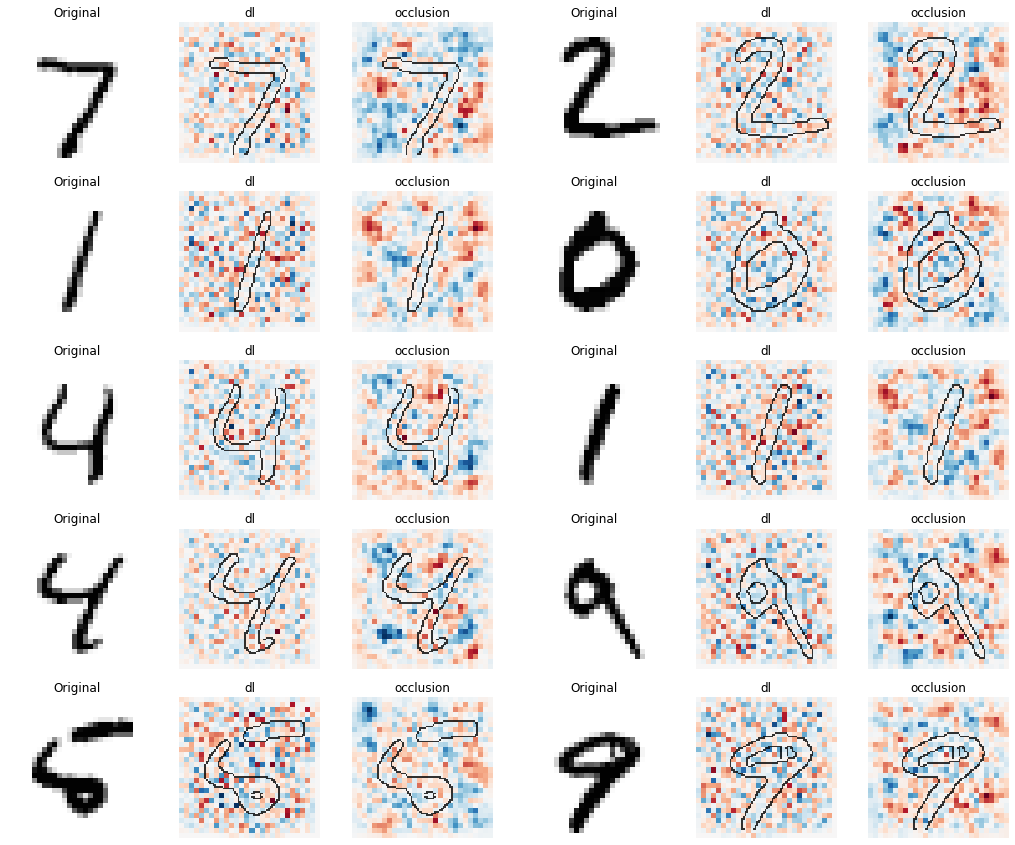

In [7]:

%%time
import matplotlib.pyplot as plt

%matplotlib inline

n_cols = 6
n_rows = int(len(attributions_gradin) / 2)
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(3*n_cols, 3*n_rows))

for i, (a1, a2) in enumerate(zip(attributions_dl, attributions_occ)):
    row, col = divmod(i, 2)
    plot(xs[i].reshape(28, 28), cmap='Greys', axis=axes[row, col*3]).set_title('Original')
    plot(a1.reshape(28,28), xi = xs[i], axis=axes[row,col*3+1]).set_title('dl')
    plot(a2.reshape(28,28), xi = xs[i], axis=axes[row,col*3+2]).set_title('occlusion')